# Feature Engineering and Time Series Feature Generation


In this Notebook, we will focus on:1) Time-series feature generation; 2) Feature generation with machine learning: case study of financial marketing with recommender systems

Sources of this tutorial: 1). https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/; 2) https://github.com/Apress/hands-on-time-series-analylsis-python; https://github.com/jyu-theartofml/Collaborative_filtering

# Time Series Feature Generation

In this part, we will use a daily stock price of Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021), which is derived from Yahoo Finance. First, the time series is loaded as a Pandas Series. We then create a new Pandas DataFrame for the transformed dataset. Next, each column is added one at a time where month and day information is extracted from the time-stamp information for each observation in the series. Below is the Python code to do this.

In [ ]:
# create date time features of a dataset
from pandas import read_csv
from pandas import DataFrame
series = read_csv('data/AAPL.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
dataframe = DataFrame()
dataframe['month'] = [series.index[i].month for i in range(len(series))]
dataframe['day'] = [series.index[i].day for i in range(len(series))]
dataframe['price'] = [series[i] for i in range(len(series))]
print(dataframe.head(15))

### Lag feature

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1). The supervised learning problem with shifted values looks as follows:

Value(t-1), Value(t+1)

Value(t-1), Value(t+1)

Value(t-1), Value(t+1)

The Pandas library provides the shift() function to help create these shifted or lag features from a time series dataset. Shifting the dataset by 1 creates the t-1 column, adding a NaN (unknown) value for the first row. The time series dataset without a shift represents the t+1

Below is an example of creating a lag feature for our daily stock price dataset. The values are extracted from the loaded series and a shifted and unshifted list of these values is created. Each column is also named in the DataFrame for clarity.

In [3]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('data/AAPL.csv', header=0, index_col=0)
temps = DataFrame(series.values)
dataframe = concat([temps.shift(1), temps], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

          t-1         t+1
0         NaN  133.990005
1  133.990005  138.050003
2  138.050003  135.580002
3  135.580002  134.080002
4  134.080002  133.520004


You can see that we would have to discard the first row to use the dataset to train a supervised learning model, as it does not contain enough data to work with.

The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width.

We can expand the window width and include more lagged features. For example, below is the above case modified to include the last 3 observed values to predict the value at the next time step.

In [4]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('data/AAPL.csv', header=0, index_col=0)
temps = DataFrame(series.values)
dataframe = concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-3', 't-2', 't-1', 't+1']
print(dataframe.head(5))

          t-3         t-2         t-1         t+1
0         NaN         NaN         NaN  133.990005
1         NaN         NaN  133.990005  138.050003
2         NaN  133.990005  138.050003  135.580002
3  133.990005  138.050003  135.580002  134.080002
4  138.050003  135.580002  134.080002  133.520004


Again, you can see that we must discard the first few rows that do not have enough data to train a supervised model. A difficulty with the sliding window approach is how large to make the window for your problem. Perhaps a good starting point is to perform a sensitivity analysis and try a suite of different window widths to in turn create a suite of different “views” of your dataset and see which results in better performing models. 

### Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean. For example, we can calculate the mean of the previous two values and use that to predict the next value. 

The first thing we need to do is shifted. Then the rolling dataset can be created and the mean values calculated on each window of two values.

In [5]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('data/AAPL.csv', header=0, index_col=0)
temps = DataFrame(series.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
dataframe = concat([means, temps], axis=1)
dataframe.columns = ['mean(t-2,t-1)', 't+1']
print(dataframe.head(5))

   mean(t-2,t-1)         t+1
0            NaN  133.990005
1            NaN  138.050003
2     136.020004  135.580002
3     136.815002  134.080002
4     134.830002  133.520004


Below is another example that shows a window width of 3 and a dataset comprised of more summary statistics, specifically the minimum, mean, and maximum value in the window. You can see in the code that we are explicitly specifying the sliding window width as a named variable. This lets us use it both in calculating the correct shift of the series and in specifying the width of the window to the rolling() function. In this case, the window width of 3 means we must shift the series forward by 2 time steps. This makes the first two rows NaN. Next, we need to calculate the window statistics with 3 values per window. It takes 3 rows before we even have enough data from the series in the window to start calculating statistics.

In [6]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('data/AAPL.csv', header=0, index_col=0)
temps = DataFrame(series.values)
width = 3
shifted = temps.shift(width - 1)
window = shifted.rolling(window=width)
dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head(5))

          min        mean         max         t+1
0         NaN         NaN         NaN  133.990005
1         NaN         NaN         NaN  138.050003
2         NaN         NaN         NaN  135.580002
3         NaN         NaN         NaN  134.080002
4  133.990005  135.873337  138.050003  133.520004


### Expanding Window Statistics

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data. Like the rolling() function on DataFrame, Pandas provides an expanding() function that collects sets of all prior values for each time step.

Below is an example of calculating the minimum, mean, and maximum values of the expanding window on the daily stock price dataset. Running the example prints the first 5 rows of the dataset.

In [7]:
# create expanding window features
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('data/AAPL.csv', header=0, index_col=0)
temps = DataFrame(series.values)
window = temps.expanding()
dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head(5))

          min        mean         max         t+1
0  133.990005  133.990005  133.990005  138.050003
1  133.990005  136.020004  138.050003  135.580002
2  133.990005  135.873337  138.050003  134.080002
3  133.990005  135.425003  138.050003  133.520004
4  133.520004  135.044003  138.050003  128.889999


 # Feature generation with machine learning: case study of financial marketing with recommender systems

In this part, we use a real-world dataset from Amazon.com.Inc. The data is from http://jmcauley.ucsd.edu/data/amazon/.

In [26]:
import numpy as np
import pandas as pd

In [27]:
df=pd.read_csv('data/ratings_Digital_Music.csv',header=None, nrows=12000)
df.head() #column order: user, items, ratings, timestamp

,0,1,2,3
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200


In [28]:
df.shape

(12000, 4)

In [29]:
n_users = df[0].unique().shape[0]
n_items = df[1].unique().shape[0]
n_rating = df[2].unique().shape[0]

print ('%i unique users' %n_users)
print ('%i unique items' %n_items)
print ('%i unique ratings' %n_rating)

9843 unique users
561 unique items
5 unique ratings


In [30]:
#generate user-item matrix
ratings=df.pivot(index=0, columns=1, values=2)

In [31]:
ratings=ratings.fillna(0).values

In [32]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 0.22%


In [33]:
# This creats a validation dataset by selecting rows (user) that have 35 or more ratings, then randomly select 15 of those ratings
#for validation set, but set those values to 0 in the training set.

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, otherwise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:# 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [34]:
train, val = train_test_split(ratings)

(9843, 561)


In [35]:
#P is latent user feature matrix
#Q is latent item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

In [36]:
lmbda = 0.4 # Regularization parameter
k = 3 #tweak this parameter
m, n = train.shape  # Number of users and items
n_epochs = 30  # Number of epochs
alpha=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [38]:
train_errors = []
val_errors = []

#Only consider items with ratings 
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

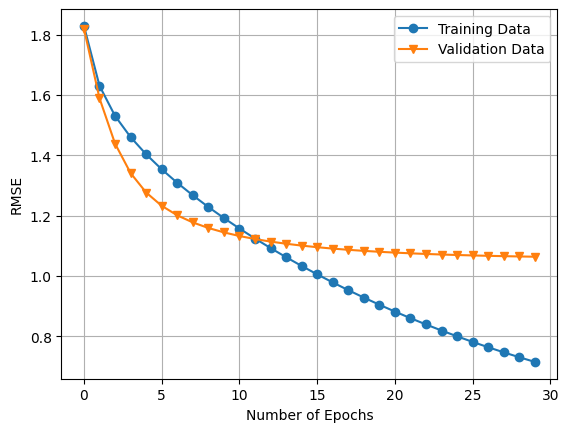

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

### Take a look at prediction vs. actual ratings

In [23]:
SGD_prediction=prediction(P,Q)

In [24]:
estimation= SGD_prediction[val.nonzero()]
ground_truth = val[val.nonzero()]
results=pd.DataFrame({'prediction':estimation, 'actual rating':ground_truth})

In [25]:
results.head()

,prediction,actual rating
0,4.171609,5.0
1,3.694285,5.0
2,2.984941,2.0
3,3.751107,5.0
4,3.556047,5.0
